In [1]:
pip install requests pandas numpy tabulate

Note: you may need to restart the kernel to use updated packages.


In [100]:
import requests
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import glob
import os

In [60]:
#Load the CSV file into a dataframe
file_path = "C:/Users/HHGiang/Documents/KEIO/4FZ/4F summer camp/TokenTerminal/Merged_Data_Clean.csv"
merged_df_clean = pd.read_csv(file_path)

In [61]:
merged_df_clean

,Date,Active users (daily) (#),Code commits (#),Core developers (#),Earnings ($),Fees ($),Market cap (circulating) ($),P/F ratio (circulating) (x),Price ($),Token trading volume ($),Token turnover (circulating) (%),Transaction count (#)
0,12/6/2020,1006,10,29,404.31,808.61,9.146935e+07,309.92,1.98,1.062730e+07,0.12,81222839
1,12/7/2020,725,39,30,378.11,756.21,8.560806e+07,299.77,1.85,1.059808e+07,0.12,82108323
2,12/8/2020,599,27,31,295.60,591.20,8.469594e+07,322.88,1.83,1.046836e+07,0.12,64508537
3,12/9/2020,551,21,31,251.39,502.79,7.764353e+07,320.03,1.67,1.711237e+07,0.22,59891419
4,12/10/2020,519,24,31,259.34,518.67,7.725853e+07,333.07,1.66,1.674300e+07,0.22,62344387
...,...,...,...,...,...,...,...,...,...,...,...,...
1384,9/20/2024,3678910,1,65,312677.50,625354.99,6.680835e+10,296.61,142.69,3.564422e+09,0.05,244011238
1385,9/21/2024,2880325,0,64,-23217561.64,611835.44,6.863837e+10,305.61,146.48,3.882734e+09,0.06,246083232
1386,9/22/2024,2978980,0,61,342121.72,684243.43,7.014033e+10,313.28,149.67,1.873292e+09,0.03,249139239
1387,9/23/2024,3360120,6,57,-22881459.45,728554.97,6.784280e+10,302.77,144.84,2.044307e+09,0.03,243006318


In [63]:
# Step 1: Ensure 'Date' Column is in Datetime Format
merged_df_clean['Date'] = pd.to_datetime(merged_df_clean['Date'])

# Handle missing values in 'Fees ($)'
merged_df_clean['Fees ($)'].fillna(0, inplace=True)

# Step 2: Extract 'Year' from 'Date'
merged_df_clean['Year'] = merged_df_clean['Date'].dt.year

# Step 3: Aggregate Data Annually
# Sum of Fees per Year
annual_fees = merged_df_clean.groupby('Year')['Fees ($)'].sum().reset_index()

# Average Price per Year
annual_price = merged_df_clean.groupby('Year')['Price ($)'].mean().reset_index()

# Combine Annual Data
annual_data = annual_fees.merge(annual_price, on='Year')

# Output the annual data
print("\nAnnual Data:")
print(annual_data)


Annual Data:
   Year      Fees ($)   Price ($)
0  2020  1.293962e+04    1.586154
1  2021  2.803106e+07   79.722904
2  2022  2.647614e+07   58.396630
3  2023  2.532615e+07   29.066411
4  2024  3.491131e+08  141.791381


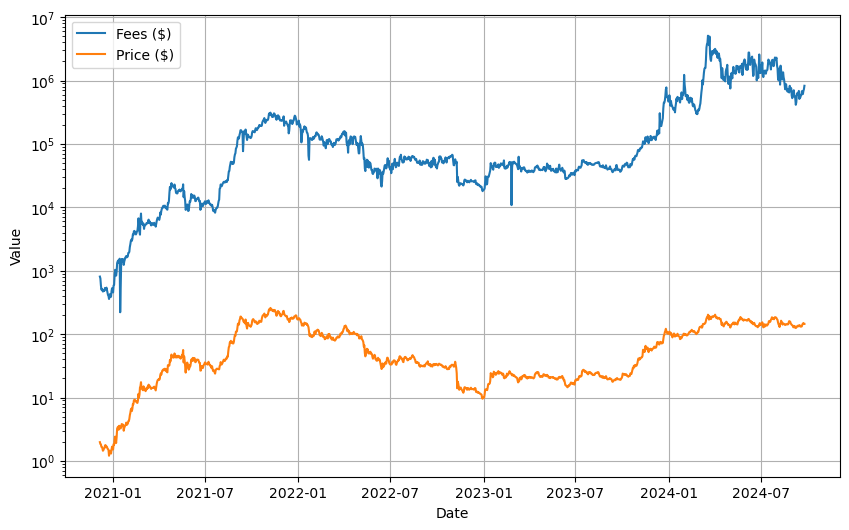

In [111]:
# Plot Fees and Price over time
plt.figure(figsize=(10, 6))

# Plotting Fees
plt.plot(merged_df_clean['Date'], merged_df_clean['Fees ($)'], label='Fees ($)')

# Plotting Price
plt.plot(merged_df_clean['Date'], merged_df_clean['Price ($)'],  label='Price ($)')

plt.xlabel('Date')
plt.ylabel('Value')
plt.yscale('log')  # Use log scale for clearer visualization
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

In [64]:
# Step 4: Set Initial Values
# Fetch total circulating supply data
def fetch_total_supply():
    try:
        response = requests.get('https://api.coingecko.com/api/v3/coins/solana')
        data = response.json()
        total_supply = data['market_data']['circulating_supply']
        return total_supply
    except Exception as e:
        print(f"Error fetching total supply: {e}")
        return None  # Or use a default value

total_supply = fetch_total_supply()
if total_supply is None:
    total_supply = 468_831_414  # Replace with the actual circulating supply

print(f"\nTotal Circulating Supply: {total_supply:.0f} SOL")

# Use the most recent year's average price
current_year = annual_data['Year'].max()
average_sol_price = annual_data.loc[annual_data['Year'] == current_year, 'Price ($)'].values[0]

print(f"\nAverage SOL Price for {current_year}: ${average_sol_price:.2f}")

# Initial Transaction Fees
initial_transaction_fees = annual_data.loc[annual_data['Year'] == current_year, 'Fees ($)'].values[0]

print(f"\nInitial Transaction Fees for {current_year}: ${initial_transaction_fees:.2f}")



Total Circulating Supply: 468831181 SOL

Average SOL Price for 2024: $141.79

Initial Transaction Fees for 2024: $349113102.71


In [113]:
# Step 5: Calculate Growth Rates --> abnormal growth rate, will explore different scenarios 
# Transaction Fee Growth Rate (CAGR)
if len(annual_data) >= 2:
    beginning_value = annual_data.iloc[0]['Fees ($)']
    ending_value = annual_data.iloc[-1]['Fees ($)']
    num_years = annual_data['Year'].nunique() 

    # Calculate CAGR
    transaction_fee_cagr = (ending_value / beginning_value) ** (1 / num_years) - 1

else:
    transaction_fee_cagr = 0.5  # Assume 50% if insufficient data


print(f"\nTransaction Fee Growth Rate (CAGR): {transaction_fee_cagr*100:.2f}%")


Transaction Fee Growth Rate (CAGR): 669.50%


In [92]:
# Step 6: Reduce Growth Rate Over Time
growth_rate_reduction = 0.10  # 10% reduction per year
years = 5  # Projection period

adjusted_growth_rates = []
current_growth_rate = transaction_fee_cagr
for i in range(years):
    adjusted_growth_rates.append(current_growth_rate)
    # Reduce the growth rate for the next year
    current_growth_rate = max(current_growth_rate * (1 - growth_rate_reduction), 0.02)  # Minimum growth rate of 2% for asjusted for USD-based value

print("\nAdjusted Growth Rates:")
for i, rate in enumerate(adjusted_growth_rates, 1):
    print(f"Year {i}: {rate*100:.2f}%")


Adjusted Growth Rates:
Year 1: 669.50%
Year 2: 602.55%
Year 3: 542.30%
Year 4: 488.07%
Year 5: 439.26%


In [93]:
# Step 7: Set Discount Rate and Exit Multiple
discount_rate = 0.15  # 15%
exit_multiple = 22.4  # Based on industry averages or analysis
inflation_rate = 0.08 # as their whitepaper claims
print(f"\nDiscount Rate: {discount_rate*100:.2f}%")
print(f"Exit Multiple: {exit_multiple:.2f}")
print(f"\nInflation Rate: {inflation_rate*100:.2f}%")


Discount Rate: 15.00%
Exit Multiple: 22.40

Inflation Rate: 8.00%


In [94]:
# Step 8: Define the DCF Model Function Using Transaction Fees
def solana_dcf_model_with_issuance(
    years,
    initial_transaction_fees,
    adjusted_growth_rates,
    discount_rate,
    exit_multiple,
    total_supply,
    inflation_rate
):
    # Initialize lists to store yearly data
    years_list = []
    transaction_fees_list = []
    new_issuance_list = []
    total_cash_flows_list = []
    discount_factor_list = []
    present_value_list = []

    transaction_fees = initial_transaction_fees

    for i in range(years):
        year = i + 1
        years_list.append(year)

        # Append transaction fees and calculate new issuance
        transaction_fees_list.append(transaction_fees)
        new_issuance = total_supply * inflation_rate
        new_issuance_list.append(new_issuance)

        # Total cash flow = transaction fees + new issuance
        total_cash_flow = transaction_fees + new_issuance
        total_cash_flows_list.append(total_cash_flow)

        # Discount factor
        discount_factor = (1 + discount_rate) ** year
        discount_factor_list.append(discount_factor)

        # Present value
        present_value = total_cash_flow / discount_factor
        present_value_list.append(present_value)

        # Update transaction fees for next year
        transaction_fees *= (1 + adjusted_growth_rates[i])

    # Terminal value
    terminal_cash_flow = total_cash_flows_list[-1]
    terminal_value = exit_multiple * terminal_cash_flow
    pv_terminal_value = terminal_value / discount_factor_list[-1]

    # Sum of present values
    total_pv_cash_flows = sum(present_value_list)
    total_pv = total_pv_cash_flows + pv_terminal_value

    # Intrinsic value per SOL
    intrinsic_value_per_sol = total_pv / total_supply

    # Prepare DataFrame to show the yearly cash flow analysis
    data = {
        'Year': years_list,
        'Transaction Fees ($)': transaction_fees_list,
        'New Issuance (SOL)': new_issuance_list,
        'Total Cash Flow ($)': total_cash_flows_list,
        'Discount Factor': discount_factor_list,
        'Present Value ($)': present_value_list
    }
    df = pd.DataFrame(data)

    # Add terminal value row
    df.loc[len(df)] = {
        'Year': 'Terminal',
        'Transaction Fees ($)': '',
        'New Issuance (SOL)': '',
        'Total Cash Flow ($)': terminal_cash_flow,
        'Discount Factor': discount_factor_list[-1],
        'Present Value ($)': pv_terminal_value
    }

    return df, intrinsic_value_per_sol

In [95]:
# Step 9: Run the DCF Model Using Transaction Fees
df_dcf_fees, intrinsic_value_per_sol_fees = solana_dcf_model_fees(
    years=years,
    initial_transaction_fees=initial_transaction_fees,
    adjusted_growth_rates=adjusted_growth_rates,
    discount_rate=discount_rate,
    exit_multiple=exit_multiple,
    total_supply=total_supply
)

In [96]:
# Step 10: Display the Results
if df_dcf_fees is not None and intrinsic_value_per_sol_fees is not None:
    print("\nDCF Calculation Results Based on Transaction Fees:")
    print(df_dcf_fees.to_string(index=False))
    print(f"\nIntrinsic Value per SOL (Fees-based): ${intrinsic_value_per_sol_fees:.2f}")
else:
    print("DCF calculation could not be completed due to missing data.")


DCF Calculation Results Based on Transaction Fees:
    Year Transaction Fees ($) Growth Rate  Discount Factor  Present Value ($)
       1         349113102.71     669.50%         1.150000       3.035766e+08
       2    2686427187.813185     602.55%         1.322500       2.031325e+09
       3   18873507106.455376     542.30%         1.520875       1.240964e+10
       4  121223674025.868469     488.07%         1.749006       6.931003e+10
       5  712875076228.674316     439.26%         2.011357       3.544249e+11
Terminal                                          2.011357       7.939118e+12

Intrinsic Value per SOL (Fees-based): $17869.11


In [117]:
# Define all four scenarios for CAGRs (same as before)
cagr_scenarios = {
    "Scenario 1 (2020-2024)": transaction_fee_cagr,  # Scenario 1: 2020-2024
    "Scenario 2 (2021-2024)": transaction_fee_cagr_2021_2024,  # Scenario 2: 2021-2024
    "Scenario 3 (2022-2024)": (annual_data.loc[annual_data['Year'] == 2024, 'Fees ($)'].values[0] /
                                annual_data.loc[annual_data['Year'] == 2022, 'Fees ($)'].values[0]) ** (1 / 2) - 1,  # CAGR for 2022-2024
    "Scenario 4 (2023-2024)": (annual_data.loc[annual_data['Year'] == 2024, 'Fees ($)'].values[0] /
                                annual_data.loc[annual_data['Year'] == 2023, 'Fees ($)'].values[0]) - 1  # Growth rate for 2023-2024
}

# Set the inflation rate (this represents SOL issuance as a percentage of total supply)
inflation_rate = 0.08  # Example: 8% annual issuance of new SOL (adjust based on real data)

# Prepare dictionaries to store the results
scenario_results = {}

# Loop through each scenario and run the DCF model, including SOL issuance
for scenario_name, cagr_value in cagr_scenarios.items():
    # Adjust growth rates for the scenario
    adjusted_growth_rates = []
    current_growth_rate = cagr_value
    for i in range(years):
        adjusted_growth_rates.append(current_growth_rate)
        current_growth_rate = max(current_growth_rate * (1 - growth_rate_reduction), 0.02)

    # Run the DCF model for the scenario, including SOL issuance
    df_dcf_fees, intrinsic_value_per_sol_fees = solana_dcf_model_with_issuance(
        years=years,
        initial_transaction_fees=initial_transaction_fees,
        adjusted_growth_rates=adjusted_growth_rates,
        discount_rate=discount_rate,
        exit_multiple=exit_multiple,
        total_supply=total_supply,
        inflation_rate=inflation_rate  # Include SOL issuance as inflation
    )

    # Store the results for this scenario
    scenario_results[scenario_name] = (df_dcf_fees, intrinsic_value_per_sol_fees)

# Display the results for all scenarios
for scenario_name, (df_dcf_fees, intrinsic_value_per_sol_fees) in scenario_results.items():
    print(f"\n{scenario_name}: DCF Calculation Results (Including SOL Issuance)")
    print(df_dcf_fees.to_string(index=False))
    print(f"\nIntrinsic Value per SOL ({scenario_name}): ${intrinsic_value_per_sol_fees:.2f}")


Scenario 1 (2020-2024): DCF Calculation Results (Including SOL Issuance)
    Year Transaction Fees ($) New Issuance (SOL)  Total Cash Flow ($)  Discount Factor  Present Value ($)
       1         349113102.71    37506494.447078         3.866196e+08         1.150000       3.361910e+08
       2    2686427187.813185    37506494.447078         2.723934e+09         1.322500       2.059685e+09
       3   18873507106.455376    37506494.447078         1.891101e+10         1.520875       1.243430e+10
       4  121223674025.868469    37506494.447078         1.212612e+11         1.749006       6.933147e+10
       5  712875076228.674316    37506494.447078         7.129126e+11         2.011357       3.544436e+11
Terminal                                                 7.129126e+11         2.011357       7.939536e+12

Intrinsic Value per SOL (Scenario 1 (2020-2024)): $17870.27

Scenario 2 (2021-2024): DCF Calculation Results (Including SOL Issuance)
    Year Transaction Fees ($) New Issuance (SOL) 